# Нейронні мережі та PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Створення класу моделі.
Для цього завдання використано набір даних "Iris". У моделі буде два прихованих рівня. У секції "Forward" моделі використаємо ReLU як функцію активації. Вона доступна як повна модель <a href='https://pytorch.org/docs/stable/nn.html#relu'>torch.nn.ReLU</a> або як функціональний виклик <a href='https://pytorch.org/docs/stable/nn.html#id27'>torch.nn.functional.relu</a>.

In [2]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # вхідний шар
        self.fc2 = nn.Linear(h1, h2)            # прихований шар
        self.out = nn.Linear(h2, out_features)  # вихідний шар
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

Створення об'єкту класу модель.

In [3]:
torch.manual_seed(4)
model = Model()

## Завантаження та візуалізація даних.

In [4]:
df = pd.read_csv('iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


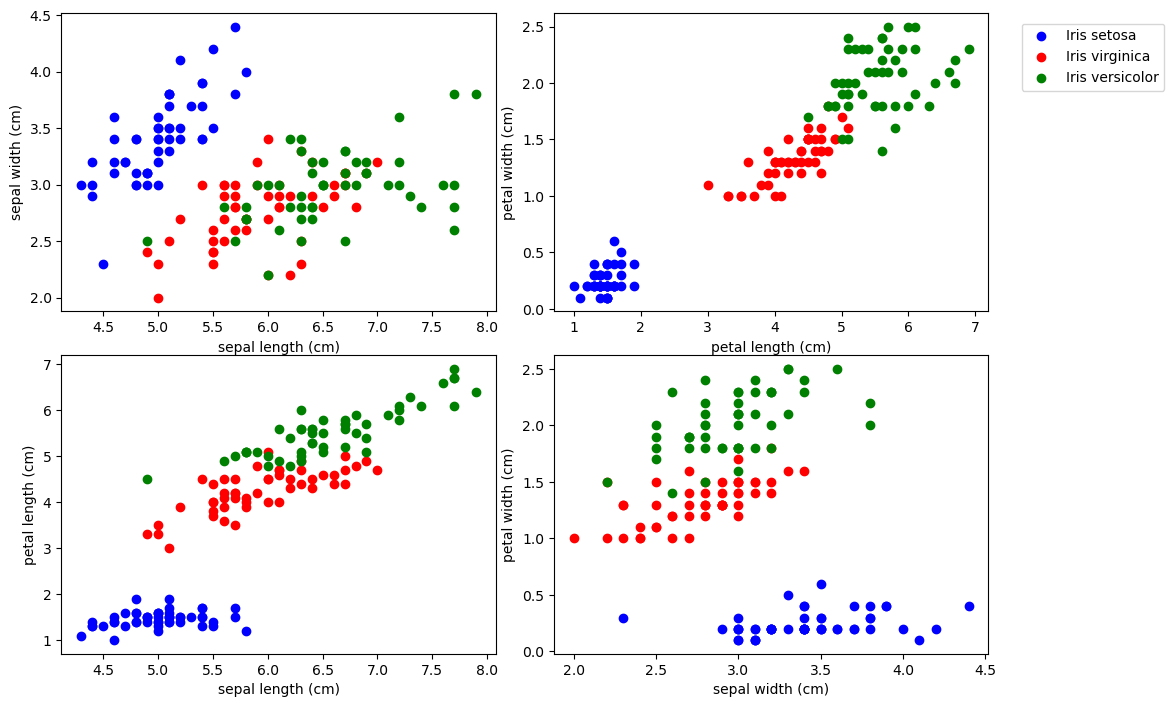

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

## Поділ даних на тестовий та тренувальний набори.

In [6]:
X = df.drop('target',axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Функція витрат та оптимізації.
Використано <a href='https://en.wikipedia.org/wiki/Cross_entropy'>Cross Entropy</a> з <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'>torch.nn.CrossEntropyLoss()</a>.<br>
Як оптимізатор, використано стохастичний градієнтний спуск, який називається <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam'>Adam</a> (Скорочено Adaptive Moment Estimation), з <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'>torch.optim.Adam()</a>.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Тренування моделі.

In [8]:
epochs = 100
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 1.09568226
epoch: 11  loss: 0.98190629
epoch: 21  loss: 0.75652379
epoch: 31  loss: 0.49447367
epoch: 41  loss: 0.34981725
epoch: 51  loss: 0.22807980
epoch: 61  loss: 0.13547555
epoch: 71  loss: 0.09162237
epoch: 81  loss: 0.07378435
epoch: 91  loss: 0.06546316


### Функція втрат.

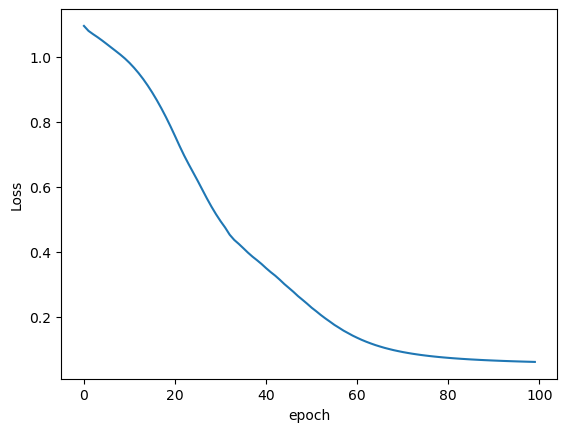

In [9]:
with torch.no_grad():
    plt.plot(range(epochs), losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch');

### Валідація моделі.

In [10]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06247772


In [12]:
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}, {y_test[i] == y_val.argmax().item()} ')
        if y_val.argmax().item() == y_test[i]:
            correct += 1
print(f'\n{correct} з {len(y_test)} = {100*correct/len(y_test):.2f}% передбачено правильно.')

 1. tensor([-0.3360,  7.3629,  1.3780])     1, True 
 2. tensor([0.2770, 8.1552, 0.4267])        1, True 
 3. tensor([ 11.9968,   6.1842, -19.1980])  0, True 
 4. tensor([-2.0192,  7.9662,  4.2445])     1, True 
 5. tensor([-6.1353,  7.9516, 11.0908])     2, True 
 6. tensor([-10.2640,   8.3102,  17.9992])  2, True 
 7. tensor([ 12.0541,   6.4316, -19.2913])  0, True 
 8. tensor([ 12.9496,   6.4815, -20.7530])  0, True 
 9. tensor([-5.7727,  8.2435, 10.5079])     2, True 
10. tensor([-7.8872,  8.6126, 14.0726])     2, True 
11. tensor([-8.7060,  8.6074, 15.4331])     2, True 
12. tensor([ 11.6348,   5.8164, -18.6210])  0, True 
13. tensor([-8.1013,  8.2331, 14.3883])     2, True 
14. tensor([-2.0796,  7.7751,  4.3185])     1, True 
15. tensor([-6.0833,  8.3916, 11.0582])     2, True 
16. tensor([0.1354, 7.8658, 0.6407])        1, True 
17. tensor([-4.0880,  7.7216,  7.6638])     2, False 
18. tensor([ 13.1511,   6.5907, -21.0787])  0, True 
19. tensor([-1.5649,  8.0220,  3.4751])     1

 ### Збереження/Завантаження моделі.
 
Після того, як модель було натреновано та перевірено її роботу, і виглядає, що модель працює добре, модель можна зберегти. Також, збережену модель можна завантажити, щоб продовжити з нею роботу. Для цього використовуються методи <a href='https://pytorch.org/docs/stable/torch.html#torch.save'>torch.save()</a> та <a href='https://pytorch.org/docs/stable/torch.html#torch.load'>torch.load()</a>.<br>

### Збереження моделі.

In [13]:
torch.save(model.state_dict(), 'IrisDatasetModel.pt')

### Завантаження та оцінка моделі.

In [14]:
new_model = Model()
new_model.load_state_dict(torch.load('IrisDatasetModel.pt'))
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [15]:
with torch.no_grad():
    y_val = new_model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06247772


### Застосування моделі з новими даними.

In [16]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

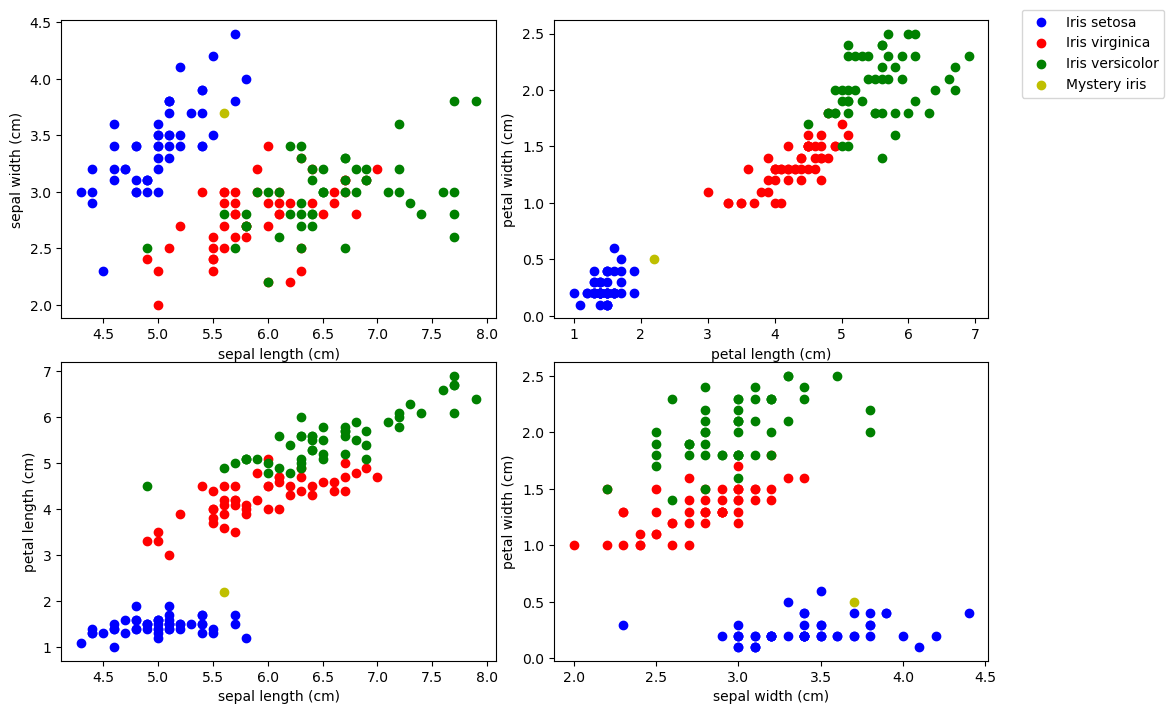

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    # Add a plot for our mystery iris:
    ax.scatter(mystery_iris[plots[i][0]],mystery_iris[plots[i][1]], color='y')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [18]:
with torch.no_grad():
    print(new_model(mystery_iris))
    print()
    print(labels[new_model(mystery_iris).argmax()])

tensor([ 12.2112,   7.1279, -19.5248])

Iris setosa
